# Dog Breed Image Classification Model

## Setup

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub
import pathlib
import pandas as pd

tf.get_logger().setLevel('ERROR')

In [2]:
# making sure that tensorflow is going to be using GPU for calculations
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Loading

In [3]:
# set up connection to folder
data_dir = "../Dog_Breed_Files/Images/"
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

20580


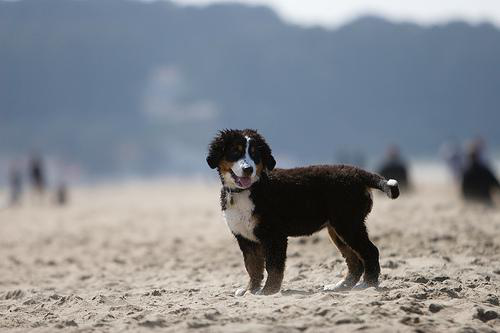

In [5]:
# confirm connection by checking out a bernese mountain dog
dog = list(data_dir.glob('n02107683-Bernese_mountain_dog/*'))
PIL.Image.open(str(dog[51]))

## Set up Data

While we're aware of the "image_dataset_from_directory()" keras utility, we're going to set up a custom image preprocessing pipeline for maximum flexibility with tuning model parameters and for deploying the model later.

We will want all of the images to be the same size. As of now we're unclear what size is going to be the best tradeoff between keeping enough detail and computation speed. Starting off at 250x250.

In [6]:
# define parameters to be used in loading and modeling
batch_size = 32
img_height = 224
img_width = 224

In [7]:
# set up a list that contains every photo in the directory
image_list = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
image_list = image_list.shuffle(image_count, reshuffle_each_iteration=False)

### Building Class Labels

In [8]:
# investigate the file path for the photos
for image in image_list.take(3):
    print(image.numpy())

b'..\\Dog_Breed_Files\\Images\\n02113712-miniature_poodle\\n02113712_112.jpg'
b'..\\Dog_Breed_Files\\Images\\n02105855-Shetland_sheepdog\\n02105855_5880.jpg'
b'..\\Dog_Breed_Files\\Images\\n02086240-Shih-Tzu\\n02086240_6795.jpg'


In [9]:
# note the folder names have a lot of extra info in them. when we get an answer at the end we'll use a dataframe to grab the cleaned name from the messy folder name
class_names = []

for folder_name in os.listdir("../Dog_Breed_Files/Images/"):
    class_names.append(folder_name)

### Set up Train/Test Split

Going to use an 80/20 train test split here. (can revisit later)

In [10]:
test_size = int(image_count*0.2)
train_data = image_list.skip(test_size)
test_data = image_list.take(test_size)

In [11]:
# check size of our training and testing data (expecting sum to be 20,580)
print(tf.data.experimental.cardinality(train_data).numpy())
print(tf.data.experimental.cardinality(test_data).numpy())
print(tf.data.experimental.cardinality(train_data).numpy() + tf.data.experimental.cardinality(test_data).numpy())

16464
4116
20580


### Functions for loading and preprocessing

In [12]:
# this will look at the file path and assign it a number [0-119] based on which dog breed it is (number is relative to where it lies in the folder structure)
def get_label(file_path):
    # take the path and separate it into components by the /
    parts = tf.strings.split(file_path, os.path.sep)
    
    # looking at the file structure above, the 2nd to last element is the class directory
    one_hot = parts[-2] == class_names

    # integer encode the label
    label = tf.argmax(one_hot)
    return label

In [13]:
# this will look at the image in a file path, turn it into an RGB array, then resize it to our desired size
def decode_image(img):
    img = tf.io.read_file(img)

    # parse the image as a uint8 tensor, 3 channels for RGB color
    img = tf.image.decode_jpeg(img, channels=3)

    # convert color channels from [0-255] to [0-1]. done here as opposed to in a model layer for increased efficiency
    img = tf.image.convert_image_dtype(img, tf.float32)

    # resize the image to  standardized size
    img = tf.image.resize(img, [img_height, img_width])
    return img

In [14]:
# this will combine the two functions above to get a label and an encoded tensor for each image it looks at
def processing(file_path):
    # get the folder name
    label = get_label(file_path)
    
    # load image, decode image
    img = decode_image(file_path)
    return img, label

In [15]:
# map the processing pipeline to each data set. 
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.map(processing)
test_data = test_data.map(processing)

In [16]:
# expecting each image to be (224, 224, 3) shape
for image, label in train_data.take(3):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  8
Image shape:  (224, 224, 3)
Label:  10
Image shape:  (224, 224, 3)
Label:  98


### Set up performance features

In [17]:
def performance_enhance(dataset):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [18]:
train_data = performance_enhance(train_data)
test_data = performance_enhance(test_data)
num_classes = len(class_names)

### Visualize what we have

In [ ]:
image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy())
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Basic Model

We know from researching that a Convolutional Neural Networks (CNN Models) are often used to classify images. We'll run our image through multiple layers of convolution and pooling and then use "flatten" to turn that array into a vector that can be read by the dense layers that follow.

We'll use the Adam optimizer. And since this is a multi-cateogry categorization problem we'll use the Sparse Categorical Crossentropy loss function.

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracyuracyuracyuracyuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 8
history = model.fit(
  train_data,
  validation_data=test_data,
  epochs=epochs
)

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This model is very bad! We can try data augmentation but that may not save it and we may end up using a transfer learning model.

## Data Augmentation

Since there are only 200ish photos for each dog breed this model is a good candidate for data augmentation, where we randomly scale, rotate, and translate the photos in order to make each photo give more information to the model.

In [ ]:
# data augmentation here
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy())
    plt.axis("off")
  
# find out why these aren't showing up as augmented images

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(
  train_data,
  validation_data=test_data,
  epochs=epochs
)

Better! But we're still hitting a ceiling on how well we can predict here.

## Transfer Learning Compare

Going to try and make a function to compare five different models

In [19]:
mobilenet_v2 = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"
mobilenet_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
efficientnet_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2"
resnet_v250 = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"

models = {
    "mobilenet_v2" : mobilenet_v2,
    "mobilenet_v3" : mobilenet_v3,
    "inception_v3" : inception_v3,
    "efficientnet_v2" : efficientnet_v2,
    "resnet_v250" : resnet_v250
}

In [20]:
def model_testing(model, epoch, training, testing, augment = False):
    base_model = hub.KerasLayer(
        model,
        input_shape=(img_height, img_width, 3),
        trainable=False)
    
    if augment == False:   
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(250, activation='relu'),
            tf.keras.layers.Dropout(.30),
            tf.keras.layers.Dense(180, activation='relu'),
            tf.keras.layers.Dropout(.20),
            tf.keras.layers.Dense(num_classes, activation = 'softmax')
        ])
    else:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
            tf.keras.layers.RandomRotation(0.15),
            tf.keras.layers.RandomZoom(0.2),
        ])
        model = tf.keras.Sequential([
            data_augmentation,
            base_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(250, activation='relu'),
            tf.keras.layers.Dropout(.30),
            tf.keras.layers.Dense(180, activation='relu'),
            tf.keras.layers.Dropout(.20),
            tf.keras.layers.Dense(num_classes, activation = 'softmax')
        ])
    
    model.build((img_height, img_width, 3))

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    
    history = model.fit(
        training,
        validation_data=testing,
        epochs=epoch,
        callbacks=[early_stopping]
        )
    
    return history

In [21]:
def visualize_metrics(metrics_dict):
    # a function to visualize all metrics from the previous function
    fig, axes = plt.subplots(nrows=5, 
                            ncols=2, 
                            figsize=(15, 25))

    fig.tight_layout(pad=5)

    plt.style.use('fivethirtyeight')

    i = 0
    j = 0
    for model, metrics in metrics_dict.items():
        axes[i][j].plot(metrics['accuracy'])
        axes[i][j].plot(metrics['val_accuracy'])
        axes[i][j].set_ylabel("Accuracy")
        axes[i][j].set_ylim((0, 1))
        axes[i][j].set_xlabel("Epochs")
        axes[i][j].set_title(f'Model {i + 1}: {model} Accuracy')
        axes[i][j].legend(['Train', 'Test'], loc='upper left')
        j += 1
        axes[i][j].plot(metrics['loss'])
        axes[i][j].plot(metrics['val_loss'])
        axes[i][j].set_ylabel("Loss")
        axes[i][j].set_ylim((0, 2))
        axes[i][j].set_xlabel("Epochs")
        axes[i][j].set_title(f'Model {i + 1}: {model} Loss')
        axes[i][j].legend(['Train', 'Test'], loc='upper left')
        i += 1
        j = 0

Epoch 1/50
515/515 [==============================] - 30s 47ms/step - loss: 1.6280 - accuracy: 0.5783 - val_loss: 0.6952 - val_accuracy: 0.7796
Epoch 2/50
515/515 [==============================] - 20s 40ms/step - loss: 0.8161 - accuracy: 0.7547 - val_loss: 0.6478 - val_accuracy: 0.7993
Epoch 3/50
515/515 [==============================] - 20s 39ms/step - loss: 0.6738 - accuracy: 0.7926 - val_loss: 0.6506 - val_accuracy: 0.8013
Epoch 4/50
515/515 [==============================] - 20s 39ms/step - loss: 0.5749 - accuracy: 0.8187 - val_loss: 0.6710 - val_accuracy: 0.8008
Epoch 5/50
515/515 [==============================] - 20s 39ms/step - loss: 0.5163 - accuracy: 0.8369 - val_loss: 0.6987 - val_accuracy: 0.7947
Epoch 6/50
515/515 [==============================] - 20s 39ms/step - loss: 0.4673 - accuracy: 0.8476 - val_loss: 0.6995 - val_accuracy: 0.7993
Epoch 7/50
515/515 [==============================] - 20s 39ms/step - loss: 0.4244 - accuracy: 0.8626 - val_loss: 0.6979 - val_accuracy:

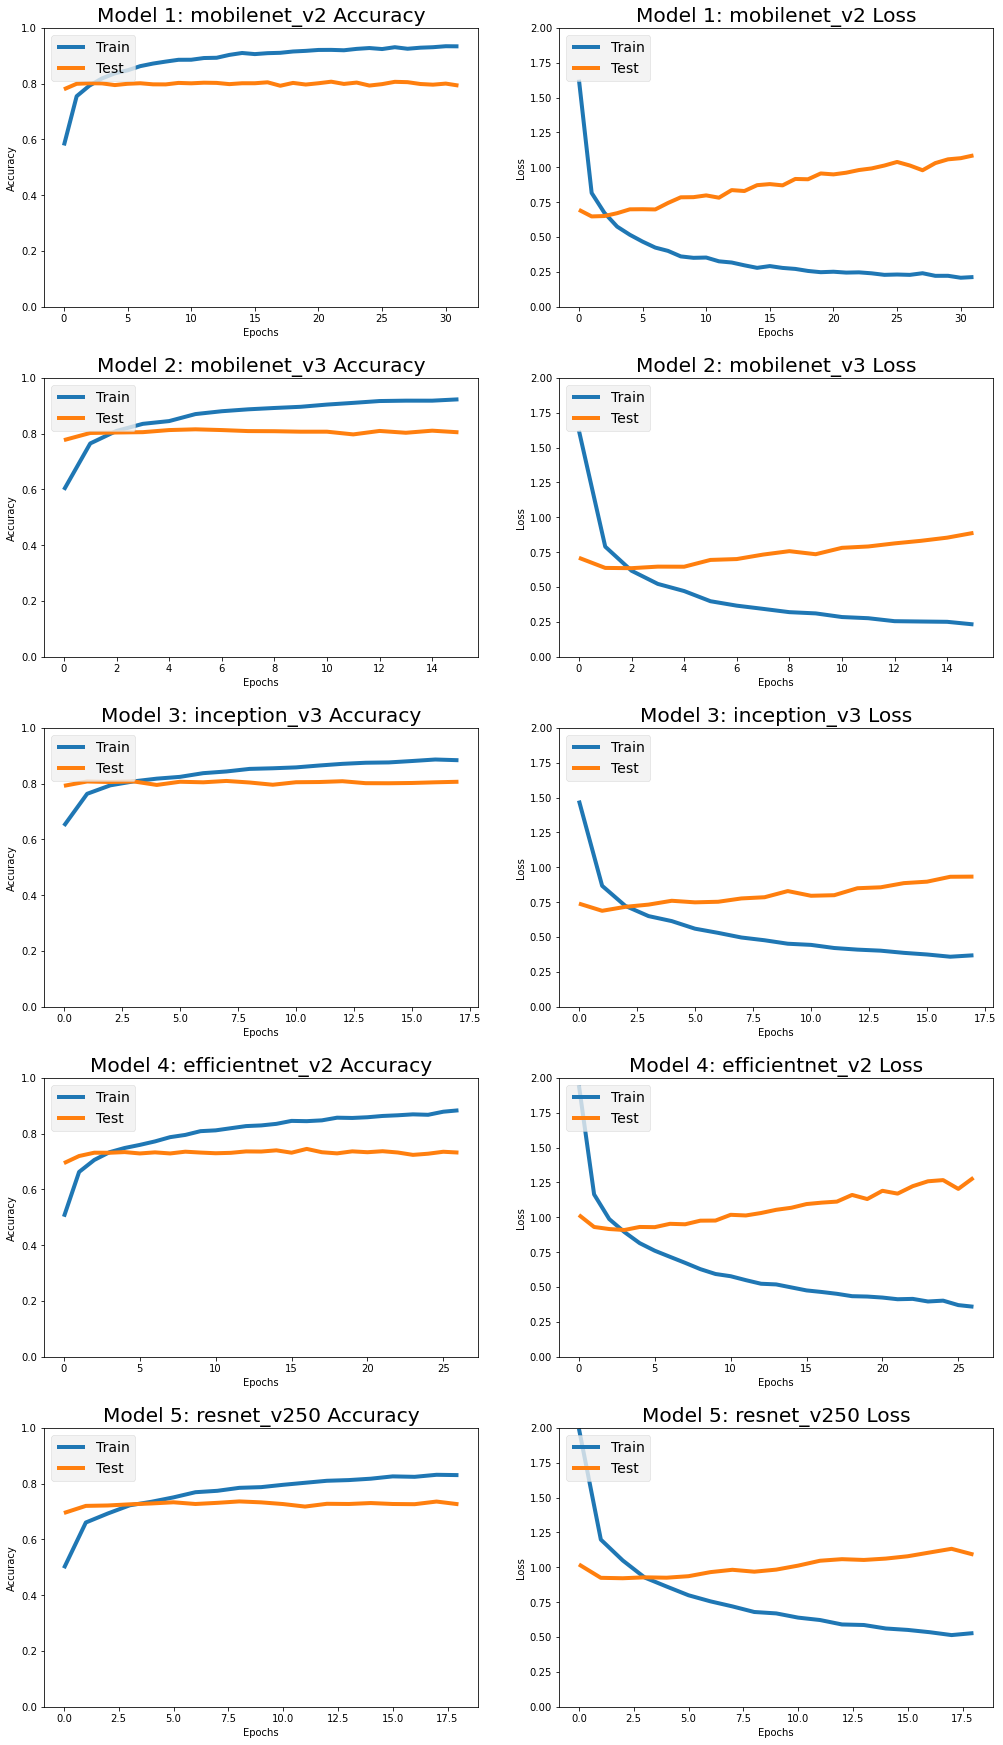

In [22]:
# first testing on non-augmented data
model_metrics_base = {}
epochs = 50

for key, value in models.items():
    history = model_testing(value, epochs, train_data, test_data, augment = False)

    model_metrics_base[key] = {
        'accuracy' : history.history['accuracy'],
        'loss' : history.history['loss'],
        'val_accuracy' : history.history['val_accuracy'],
        'val_loss' : history.history['val_loss']
    }

visualize_metrics(model_metrics_base)

In [42]:
model_metrics_base_df = pd.DataFrame(model_metrics_base).transpose()
model_metrics_base_df.to_csv("with_augmentation.csv")

Epoch 1/25
515/515 [==============================] - 118s 219ms/step - loss: 2.4013 - accuracy: 0.4078 - val_loss: 0.7965 - val_accuracy: 0.7512
Epoch 2/25
515/515 [==============================] - 112s 217ms/step - loss: 1.5399 - accuracy: 0.5691 - val_loss: 0.7151 - val_accuracy: 0.7711
Epoch 3/25
515/515 [==============================] - 111s 216ms/step - loss: 1.3935 - accuracy: 0.6066 - val_loss: 0.7004 - val_accuracy: 0.7823
Epoch 4/25
515/515 [==============================] - 111s 216ms/step - loss: 1.3069 - accuracy: 0.6276 - val_loss: 0.6498 - val_accuracy: 0.7957
Epoch 5/25
515/515 [==============================] - 112s 217ms/step - loss: 1.2476 - accuracy: 0.6435 - val_loss: 0.6655 - val_accuracy: 0.7903
Epoch 6/25
515/515 [==============================] - 112s 218ms/step - loss: 1.2291 - accuracy: 0.6474 - val_loss: 0.6482 - val_accuracy: 0.7945
Epoch 7/25
515/515 [==============================] - 112s 217ms/step - loss: 1.1845 - accuracy: 0.6577 - val_loss: 0.6544 -

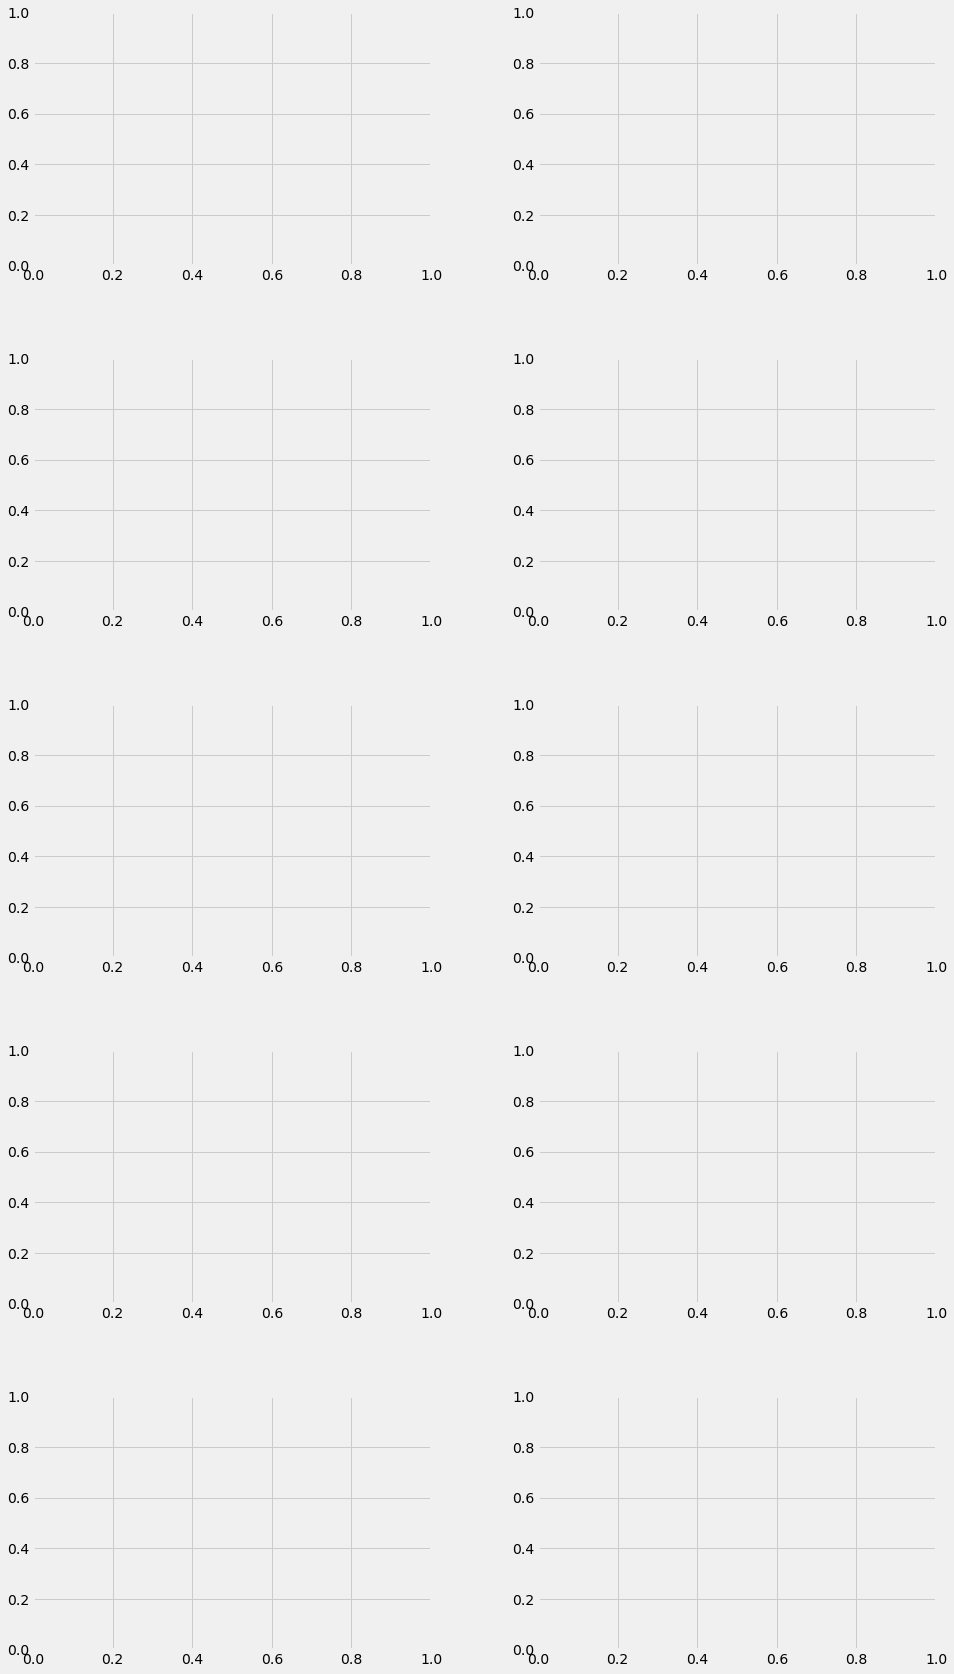

In [35]:
# now on augmented data
model_metrics_augment = {}
epochs = 25

for key, value in models.items():
    history = model_testing(value, epochs, train_data, test_data, augment = True)

    model_metrics_augment[key] = {
        'accuracy' : history.history['accuracy'],
        'loss' : history.history['loss'],
        'val_accuracy' : history.history['val_accuracy'],
        'val_loss' : history.history['val_loss']
    }

visualize_metrics(model_metrics_augment)

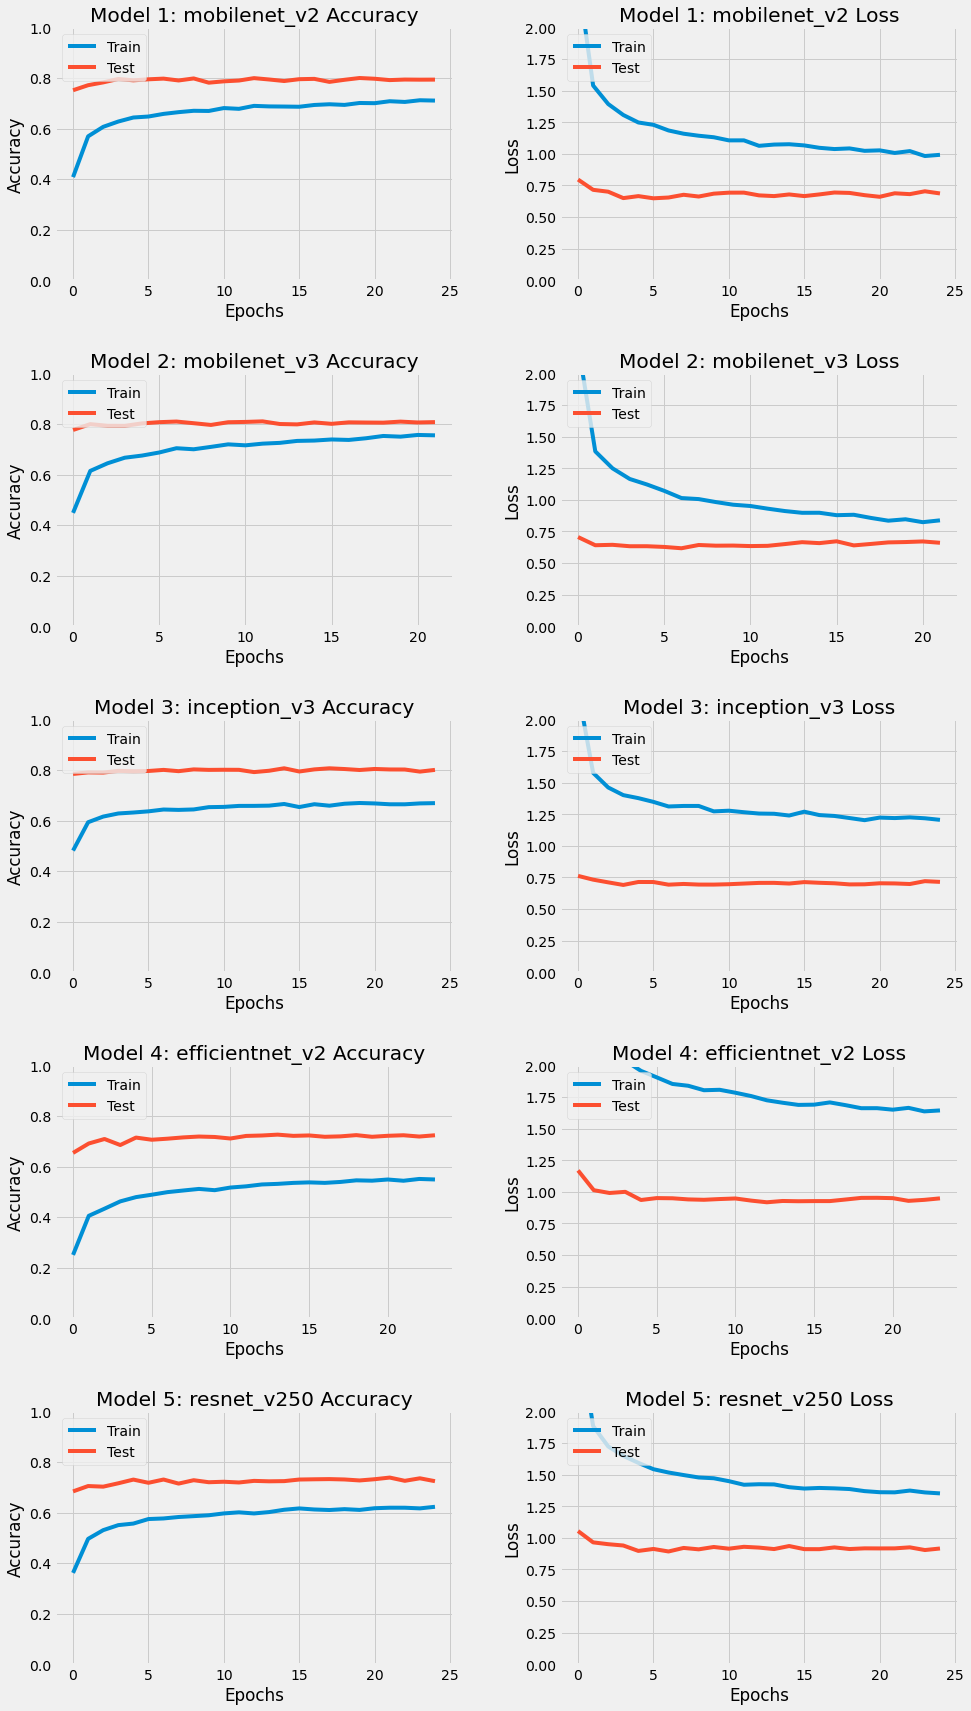

In [41]:
visualize_metrics(model_metrics_base)

In [ ]:
model_metrics_augment_df = pd.DataFrame(model_metrics_augment).transpose()
model_metrics_augment_df.to_csv("with_augmentation.csv")

In [45]:
# Model URL for ResNet50V2
MODEL_URL3 = "https://tfhub.dev/tensorflow/resnet_50/classification/1"

# Creating the model for ResNet50V2
model3 = tf.keras.Sequential([
    # Layer 1 : Input Layer
    hub.KerasLayer(MODEL_URL3),
    
    # Layer 2 : Output Layer
    tf.keras.layers.Dense(120, activation='softmax')
])

# Compiling the model
model3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# Building the model
model3.build((None, img_height, img_width, 3))

# Summary of the model
model3.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_18 (KerasLayer)  (None, 1001)             25612201  
                                                                 
 dense_50 (Dense)            (None, 120)               120240    
                                                                 
Total params: 25,732,441
Trainable params: 120,240
Non-trainable params: 25,612,201
_________________________________________________________________


In [47]:
# Creating Tensorflow EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=5)
                                                  
# Fitting the model
history3 = model3.fit(train_data,
                      epochs=30,
                      validation_data=test_data,
                      callbacks=[early_stopping])

Epoch 1/30


ValueError: in user code:

    File "c:\Users\ryang\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ryang\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ryang\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ryang\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ryang\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 1053, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses
    File "c:\Users\ryang\anaconda3\envs\mlenv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ryang\anaconda3\envs\mlenv\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\ryang\anaconda3\envs\mlenv\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ryang\anaconda3\envs\mlenv\lib\site-packages\keras\losses.py", line 1991, in categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis
    File "c:\Users\ryang\anaconda3\envs\mlenv\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 120) are incompatible
